In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger 
import cv2

In [2]:
IMG_SIZE = (128, 128)
VALID_SPLIT = 0.3
BATCH_SIZE = 16
SEED = 42

PATH = r"C:\Users\HP\Desktop\Dataset"
# Get train image with generator
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Get validation image with generator
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 1738 files belonging to 30 classes.
Using 1217 files for training.
Found 1738 files belonging to 30 classes.
Using 521 files for validation.


In [3]:
# Get class names
classes = train_ds.class_names
print(classes)

['Gobi', 'Laddu', 'Noodels', 'Pasta', 'Sandwich', 'Steam momos', 'bhindi_masala', 'broccoli', 'burger', 'chana_masala', 'chapati', 'gajar_ka_halwa', 'gulab_jamun', 'idli', 'jalebi', 'kadai_paneer', 'kofta', 'lassi', 'modak', 'mojito', 'mushroom', 'mysore_pak', 'naan', 'neer_dosa', 'onion_pakoda', 'palak_paneer', 'pizza', 'ragi_balls', 'rasmalai', 'sweet_corn']


In [4]:
# Data augmentation: kind of transformations
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
])


# Apply transformation to train data
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
print(augmented_train_ds)
# Configure the dataset for performance
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


<MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30), dtype=tf.float32, name=None))>


In [5]:
#RESNET50
def make_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

print(IMG_SIZE + (3,))

(128, 128, 3)


In [6]:
# Create model
model = make_model(input_shape=IMG_SIZE + (3,), num_classes=len(classes))
# Freeze the pre-trained layers
for layer in model.layers[:-10]:
    layer.trainable = False

# Parameters
EPOCHS = 50
CALLBACK = [
    keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    keras.callbacks.EarlyStopping(patience=15),
    CSVLogger(filename='training_history.csv') 
]

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)

history = model.fit(
    augmented_train_ds,
    epochs=EPOCHS,
    callbacks=CALLBACK,
    validation_data=val_ds,
)

Epoch 1/50
77/77 [==============================] - 35s 142ms/step - loss: 2.2523 - categorical_accuracy: 0.4289 - val_loss: 3.9544 - val_categorical_accuracy: 0.4203
Epoch 2/50
77/77 [==============================] - 9s 108ms/step - loss: 1.0573 - categorical_accuracy: 0.6968 - val_loss: 2.1212 - val_categorical_accuracy: 0.5643
Epoch 3/50
77/77 [==============================] - 9s 111ms/step - loss: 0.7899 - categorical_accuracy: 0.7576 - val_loss: 1.6888 - val_categorical_accuracy: 0.5854
Epoch 4/50
77/77 [==============================] - 9s 111ms/step - loss: 0.5528 - categorical_accuracy: 0.8118 - val_loss: 1.5332 - val_categorical_accuracy: 0.6372
Epoch 5/50
77/77 [==============================] - 9s 118ms/step - loss: 0.5013 - categorical_accuracy: 0.8332 - val_loss: 1.9339 - val_categorical_accuracy: 0.6142
Epoch 6/50
77/77 [==============================] - 9s 111ms/step - loss: 0.4753 - categorical_accuracy: 0.8546 - val_loss: 1.9387 - val_categorical_accuracy: 0.6065
Epo

In [7]:
model.save("my_model.h5")

In [8]:
# Load the model
model = tf.keras.models.load_model("my_model.h5")
classes= 'Gobi', 'Laddu', 'Noodels', 'Pasta', 'Sandwich', 'Steam momos', 'bhindi_masala', 'broccoli', 'burger', 'chana_masala', 'chapati', 'gajar_ka_halwa', 'gulab_jamun', 'idli', 'jalebi', 'kadai_paneer', 'kofta', 'lassi', 'modak', 'mojito', 'mushroom', 'mysore_pak', 'naan', 'neer_dosa', 'onion_pakoda', 'palak_paneer', 'pizza', 'ragi_balls', 'rasmalai', 'sweet_corn'

1/1 [==============================] - 11s 11s/step


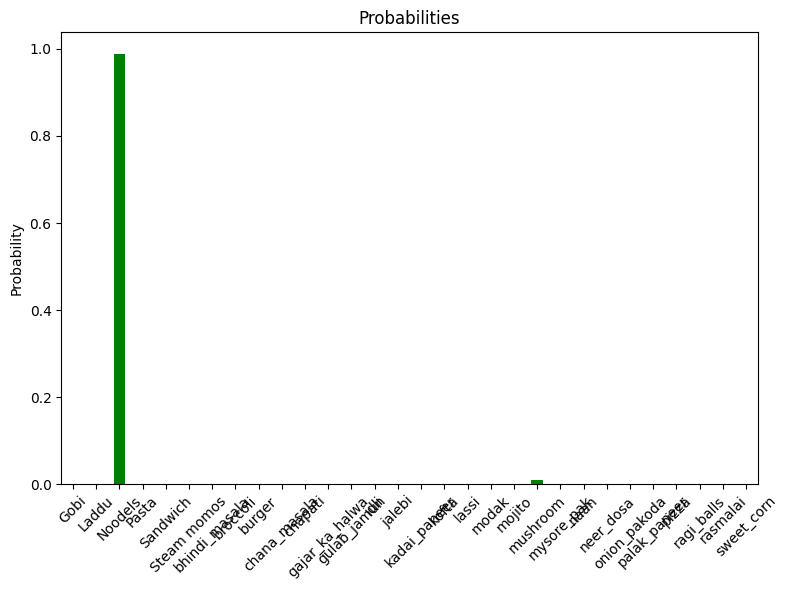

1/1 [==============================] - 0s 42ms/step


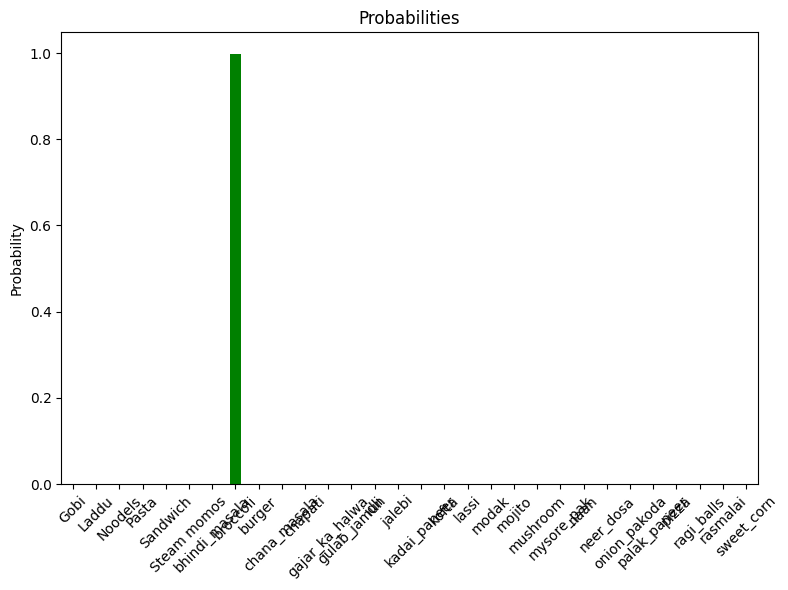

1/1 [==============================] - 0s 37ms/step


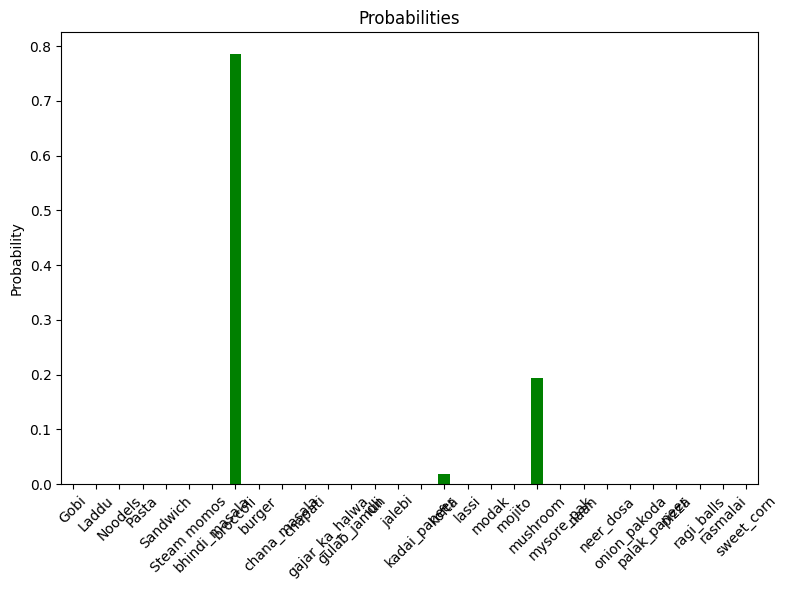

1/1 [==============================] - 0s 37ms/step


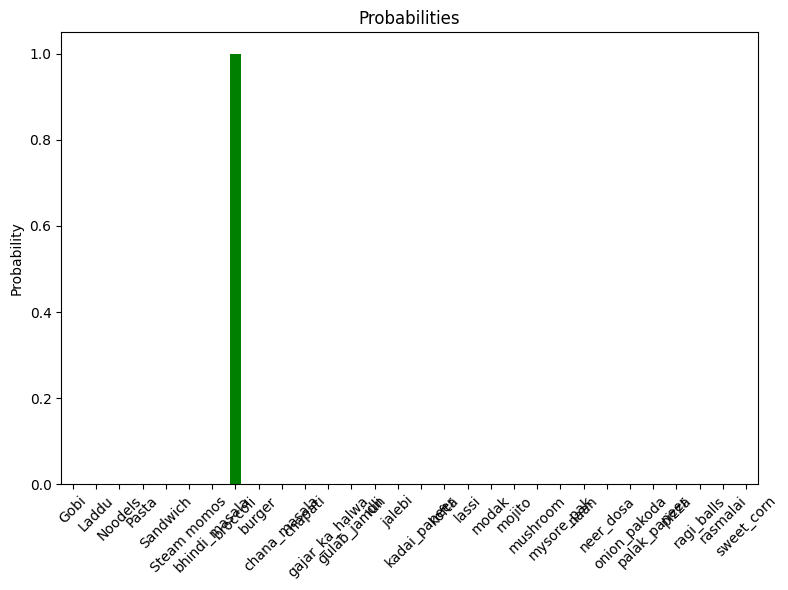

1/1 [==============================] - 0s 40ms/step


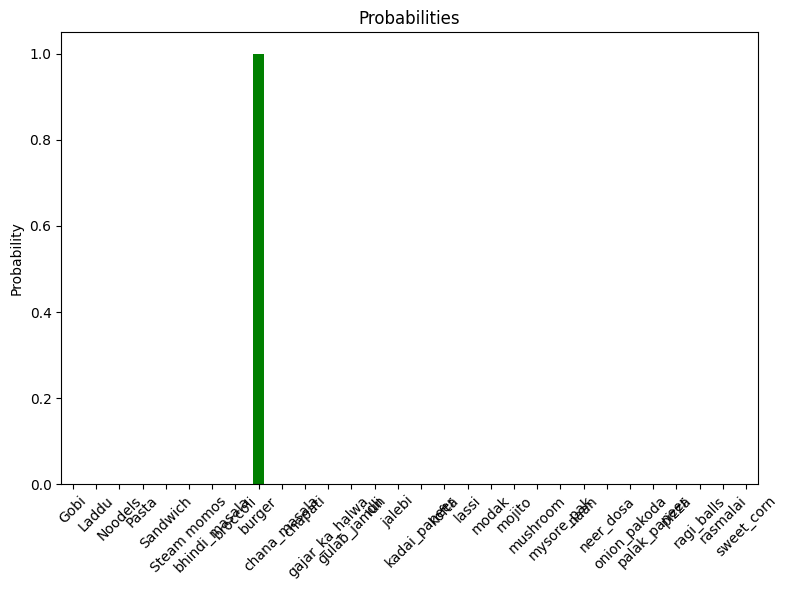

1/1 [==============================] - 0s 42ms/step


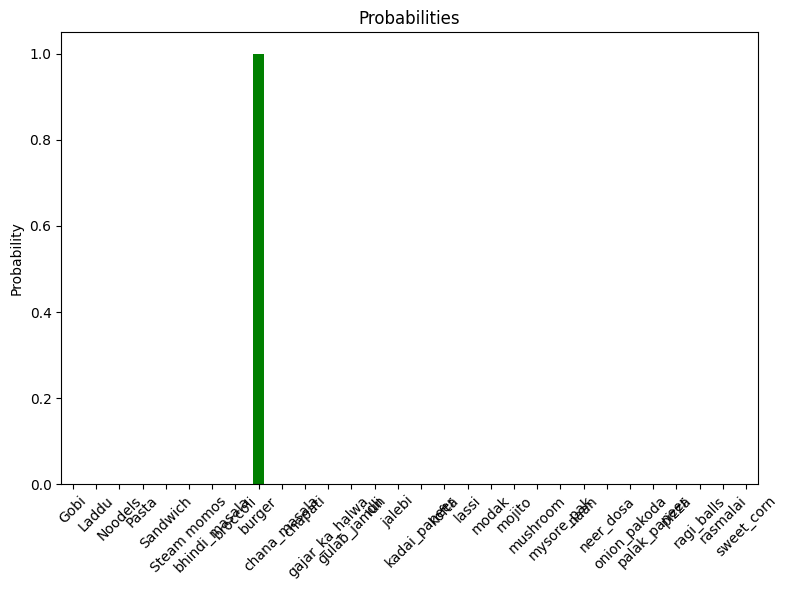

1/1 [==============================] - 0s 40ms/step


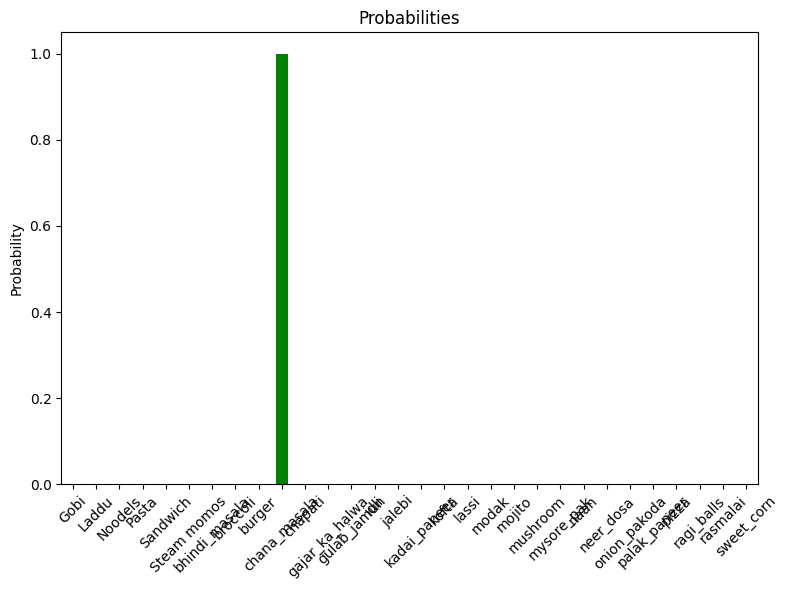

1/1 [==============================] - 0s 42ms/step


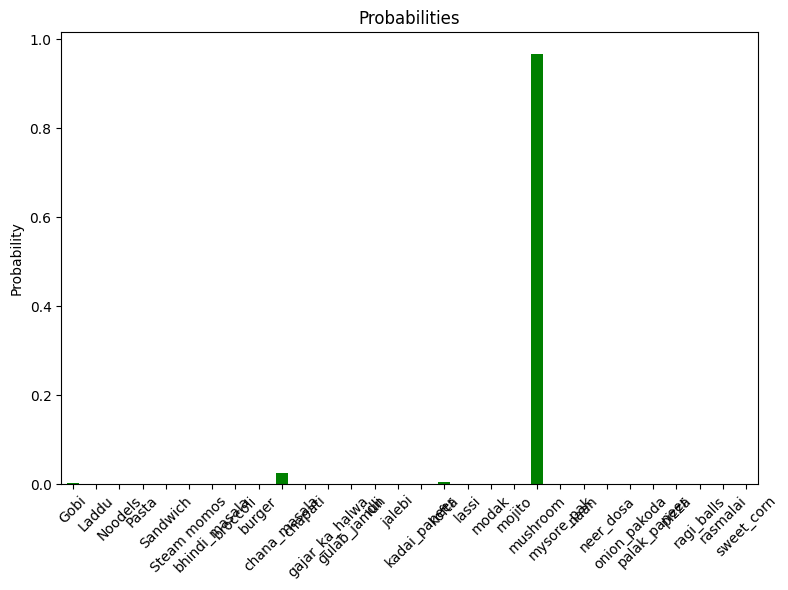

1/1 [==============================] - 0s 43ms/step


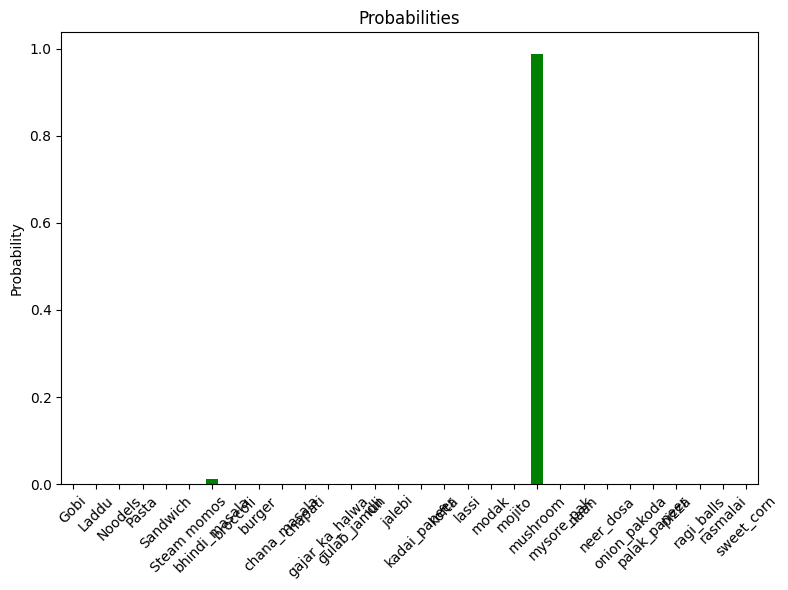

1/1 [==============================] - 0s 44ms/step


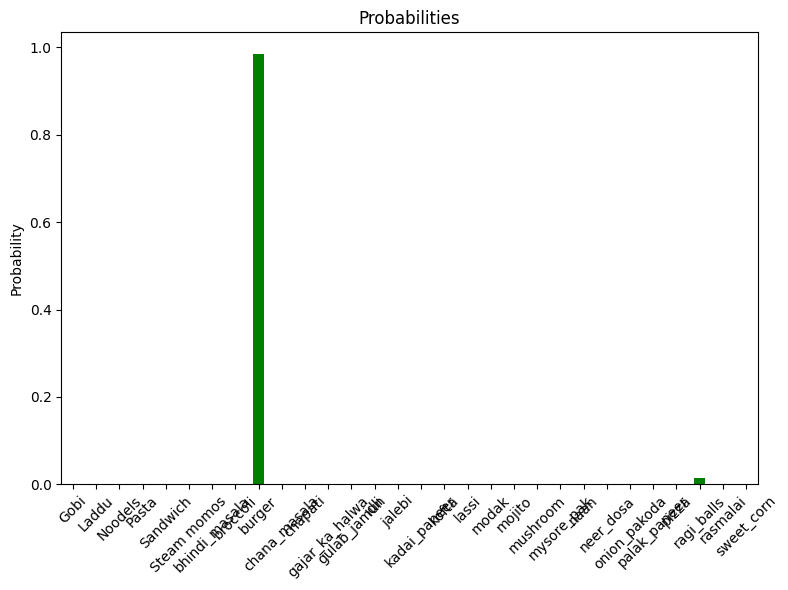

1/1 [==============================] - 0s 41ms/step


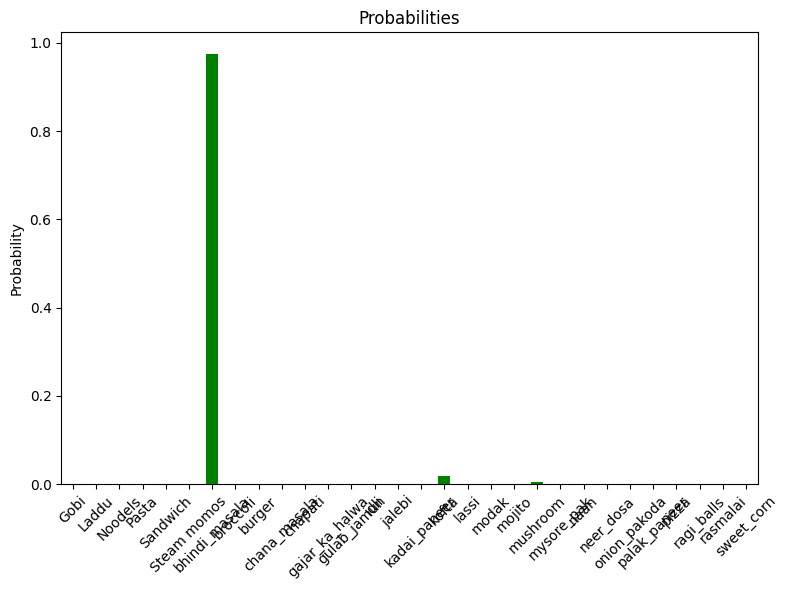

In [1]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import ImageTk, Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

model_path = 'my_model.h5'
model = tf.keras.models.load_model(model_path)

classes = ['Gobi', 'Laddu', 'Noodels', 'Pasta', 'Sandwich', 'Steam momos', 'bhindi_masala', 'broccoli', 'burger', 'chana_masala', 'chapati', 'gajar_ka_halwa', 'gulab_jamun', 'idli', 'jalebi', 'kadai_paneer', 'kofta', 'lassi', 'modak', 'mojito', 'mushroom', 'mysore_pak', 'naan', 'neer_dosa', 'onion_pakoda', 'palak_paneer', 'pizza', 'ragi_balls', 'rasmalai', 'sweet_corn']

IMG_SIZE = (128, 128)

THRESHOLD = 0.65

def predict_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        try:
            raw_img = Image.open(file_path)
            raw_img = raw_img.resize(IMG_SIZE) 
        except:
            messagebox.showerror("Error", "Failed to load the image!")
            return

        img_array = np.array(raw_img)

        img_array = np.expand_dims(img_array, 0)  

        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

        predictions = model.predict(img_array)

        series = pd.Series(predictions[0])

        proba = np.max(predictions)
        pred_class = classes[np.argmax(predictions)]

        if proba < THRESHOLD:
            messagebox.showerror("Error", "The image does not appear to be a recognized food item!")
            return

        top = tk.Toplevel()
        top.title("Prediction Result")

        label_img = tk.Label(top)
        label_img.pack()
        photo = ImageTk.PhotoImage(raw_img)
        label_img.config(image=photo)
        label_img.image = photo

        label_pred = tk.Label(top, text=f"This image may be {pred_class} at {round(proba * 100, 2)}%")
        label_pred.pack()

        fig, ax = plt.subplots(figsize=(8, 6))
        series.plot(kind='bar', color='green', ax=ax)
        ax.set_xticklabels(classes, rotation=45)
        ax.set_title("Probabilities")
        ax.set_ylabel("Probability")
        plt.tight_layout()
        plt.show()
    else:
        messagebox.showerror("Error", "No image selected!")


root = tk.Tk()
root.title("Image Classifier")

btn_upload = tk.Button(root, text="Upload Image", command=predict_image)
btn_upload.pack(pady=20)

root.mainloop()


In [5]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import ImageTk, Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Load the trained model
model_path = 'my_model.h5'
model = tf.keras.models.load_model(model_path)

# Assuming you have your classes defined
classes = ['Gobi', 'Laddu', 'Noodels', 'Pasta', 'Sandwich', 'Steam momos', 'bhindi_masala', 'broccoli', 'burger', 'chana_masala', 'chapati', 'gajar_ka_halwa', 'gulab_jamun', 'idli', 'jalebi', 'kadai_paneer', 'kofta', 'lassi', 'modak', 'mojito', 'mushroom', 'mysore_pak', 'naan', 'neer_dosa', 'onion_pakoda', 'palak_paneer', 'pizza', 'ragi_balls', 'rasmalai', 'sweet_corn']

# Load recipe details from CSV
recipe_df = pd.read_csv('Food_class.csv')

# Define image size
IMG_SIZE = (128, 128)

# Define a probability threshold
THRESHOLD = 0.65

def predict_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        try:
            # Load the image
            raw_img = Image.open(file_path)
            raw_img = raw_img.resize(IMG_SIZE)  # Resize image to match model input size
        except:
            messagebox.showerror("Error", "Failed to load the image!")
            return

        # Convert to numpy array
        img_array = np.array(raw_img)

        # Reshaping
        img_array = np.expand_dims(img_array, 0)  # Create batch axis

        # Preprocess input for the model
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

        # Make predictions
        predictions = model.predict(img_array)

        # Create a Pandas Series from predictions
        series = pd.Series(predictions[0])

        # Get score
        proba = np.max(predictions)
        pred_class = classes[np.argmax(predictions)]

        if proba < THRESHOLD:
            messagebox.showerror("Error", "The image does not appear to be a recognized food item!")
            return

        # Fetch recipe details
        recipe_details = recipe_df[recipe_df['class_name'] == pred_class].iloc[0]
        ingredient_name = recipe_details['ingredient_name']
        instruction_list = recipe_details['instruction_list']
        nutritional_info = recipe_details['nutritional_info']
        cooking_time = recipe_details['cooking_time']

        # Display results
        top = tk.Toplevel()
        top.title("Prediction Result")

        label_img = tk.Label(top)
        label_img.pack()
        photo = ImageTk.PhotoImage(raw_img)
        label_img.config(image=photo)
        label_img.image = photo

        label_pred = tk.Label(top, text=f"This image may be {pred_class} at {round(proba * 100, 2)}%")
        label_pred.pack()

        label_ingredients = tk.Label(top, text=f"Ingredients: {ingredient_name}")
        label_ingredients.pack()

        label_instructions = tk.Label(top, text=f"Instructions: {instruction_list}")
        label_instructions.pack()

        label_nutritional_info = tk.Label(top, text=f"Nutritional Info: {nutritional_info}")
        label_nutritional_info.pack()

        label_cooking_time = tk.Label(top, text=f"Cooking Time: {cooking_time}")
        label_cooking_time.pack()

        fig, ax = plt.subplots(figsize=(8, 6))
        series.plot(kind='bar', color='green', ax=ax)
        ax.set_xticklabels(classes, rotation=45)
        ax.set_title("Probabilities")
        ax.set_ylabel("Probability")
        plt.tight_layout()
        plt.show()
    else:
        messagebox.showerror("Error", "No image selected!")

root = tk.Tk()
root.title("Image Classifier")

btn_upload = tk.Button(root, text="Upload Image", command=predict_image)
btn_upload.pack(pady=20)

root.mainloop()
